In [1]:
import os
os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\hyli93\Miniconda3\envs\py3gpu\Library\bin"
#os.environ['NUMBA_ENABLE_CUDASIM']="1"

import sys
sys.path.append('C:/Users/hyli93/Documents/GitHub/Phasing/')

import phase
import phase.gpuutil2d as gpuutil

from pyculib import fft as pfft
from numba import cuda
import numpy as np
from skimage import measure as ms
import matplotlib.pyplot as plt
import math
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Load pattern

The image size is 651 by 597


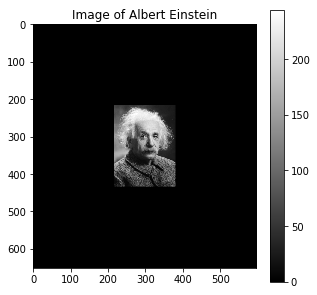

In [2]:
############################################################################################################################################
# Load the pattern
############################################################################################################################################
#Read in source image
source = plt.imread("../tests/samples/Albert_Einstein.jpg",format="jpg")

# Because the original image is too large downsample the image by a factor of 20
source = ms.block_reduce(source, (20,20), np.mean)

############################################################################################################################################
# Simulate the oversampling
############################################################################################################################################
## pad_len is the size of the support
pad_len = source.shape[0]
padded = np.pad(source, ((pad_len, pad_len),(pad_len, pad_len)), 'constant', 
                constant_values=((0,0),(0,0)))

#Show this figure
fig = plt.figure(figsize=(5,5))
plt.imshow(padded, cmap="gray")
plt.colorbar()
plt.title("Image of Albert Einstein")
print("The image size is %d by %d"%(padded.shape[0], padded.shape[1]))

# Get Diffraction intensity and the mask

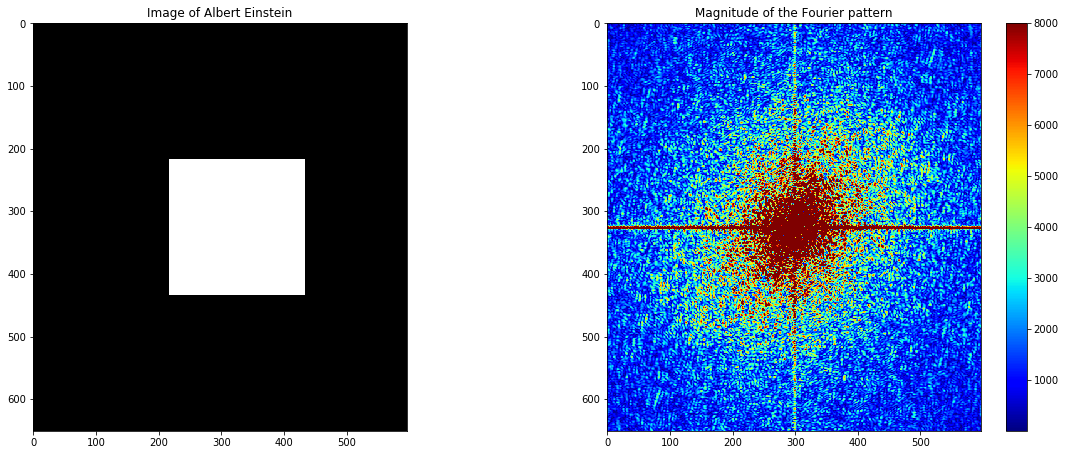

The image size is 651 by 597


In [3]:
# Calculate the fourier transformation
fourier_pattern = np.fft.ifftshift(np.fft.fft2(padded))

#simulate diffraction pattern
intensity = np.square(np.abs(fourier_pattern))

#keep track of where the image is vs the padding
length, width = padded.shape
#keep track of where the image is vs the padding
mask_float = np.zeros_like(padded, dtype=np.int64)
mask_float[pad_len:2*pad_len, pad_len:2*pad_len] = 1

mask_bool = np.zeros_like(mask_float)
mask_bool[mask_float>=0.5] = True


#Show this mask and the diffraction magnitude
magnitude = np.abs(fourier_pattern)

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(20)
fig.set_figheight(7.5)

axes[0].imshow(mask_float, cmap='gray')
axes[0].set_title("Image of Albert Einstein")

tmp = axes[1].imshow(magnitude, cmap='jet', vmax=8e3)
axes[1].set_title("Magnitude of the Fourier pattern")

fig.colorbar(mappable=tmp, ax=axes[1])

plt.show()
print("The image size is %d by %d"%(mask_bool.shape[0], mask_bool.shape[1]))

# Initialize the calculation

In [4]:
############################################################################################################################################
# Step 1: Initialize the variables
############################################################################################################################################
# Shift the magnitude
diffract = np.fft.fftshift(magnitude)
diffract = diffract.astype(np.complex128)
shape_0, shape_1 = diffract.shape
pixel_number = shape_0 * shape_1

# Shift the mask
mask_bool = np.fft.fftshift(mask_bool)

# Variable containg guessed phase to test.
guess_diffraction = diffract * np.exp(1j * np.random.rand(length,width) * 2 * np.pi)

# number of iterations
r = 800

# step size parameter
beta = 0.8

############################################################################################################################################
# Step 2: Define variables to hold data during the calculation
############################################################################################################################################

# variable to hold the result multiplied with the magnitude constrain
magnitude_constrain_pattern = np.ones_like(diffract, dtype=np.complex128)

# variable to hold the result of modified_by_maginitude under inversely fourier transformation
ifft_pattern = np.ones_like(diffract, dtype=np.complex128)
real_ifft_pattern = np.ones_like(diffract, dtype=np.float64)

# variable to hold the result of ifft_pattern modified by the real space constrain
real_constrain_ifft_pattern = np.ones_like(diffract, dtype=np.float64)
real_constrain_ifft_pattern_complex = np.ones_like(diffract, dtype=np.complex128)

# variable to store the previous guess
guess_real_space = np.ones_like(diffract, dtype=np.float64)


# Begin the calculation

In [5]:
tic = time.time()

TPB = 16

# Configure the blocks
threadsperblock = (TPB, TPB)
blockspergrid_x = int( math.ceil(shape_0 / threadsperblock[1]) )
blockspergrid_y = int( math.ceil(shape_1 / threadsperblock[0]) )
blockspergrid = (blockspergrid_x, blockspergrid_y)



############################################################################################################################################
# Step 1: Move all the variables to the gpu
############################################################################################################################################
gpu_diffract = cuda.to_device(diffract)
gpu_mask_bool = cuda.to_device(mask_bool)
gpu_magnitude_constrain_pattern = cuda.to_device(magnitude_constrain_pattern)
gpu_ifft_pattern = cuda.to_device(ifft_pattern)
gpu_real_ifft_pattern = cuda.to_device(real_ifft_pattern)
gpu_real_constrain_ifft_pattern = cuda.to_device(real_constrain_ifft_pattern)
gpu_guess_real_space = cuda.to_device(guess_real_space)
gpu_guess_diffract = cuda.to_device(guess_diffraction)
gpu_real_constrain_ifft_pattern_complex = cuda.to_device(real_constrain_ifft_pattern_complex)

"""############################################################################################################################################
# Step 2: Calculate the first step
############################################################################################################################################
gpuutil.apply_diffraction_constrain[blockspergrid, threadsperblock](shape_0,
                                                                            shape_1,
                                                                            gpu_diffract,
                                                                            gpu_guess_diffract,
                                                                            gpu_magnitude_constrain_pattern
                                                                            )

pfft.fft(ary = gpu_magnitude_constrain_pattern, 
         out = gpu_ifft_pattern)

gpuutil.get_real_part[blockspergrid, threadsperblock](shape_0,
                                                              shape_1,
                                                              gpu_guess_real_space,
                                                              gpu_ifft_pattern
                                                            )"""

############################################################################################################################################
# Step 3: Begin calculation
############################################################################################################################################
# Begin the loop
for s in range(r):
    
    pfft.ifft(ary = gpu_magnitude_constrain_pattern, 
             out = gpu_ifft_pattern)
    
    gpuutil.get_real_part[blockspergrid, threadsperblock](shape_0,
                                                                  shape_1,
                                                                  gpu_real_ifft_pattern,
                                                                  gpu_ifft_pattern
                                                                )
    
    #apply real space constraints
    gpuutil.apply_real_space_constrain_and_update_guess[blockspergrid, threadsperblock](shape_0,
                                                                                                shape_1,
                                                                                                beta,
                                                                                                gpu_real_ifft_pattern,
                                                                                                gpu_mask_bool,
                                                                                                gpu_real_constrain_ifft_pattern,
                                                                                                gpu_guess_real_space
                                                                                                )
    gpuutil.cast_to_complex[blockspergrid, threadsperblock](shape_0,
                                                                    shape_1,
                                                                    gpu_real_constrain_ifft_pattern,
                                                                    gpu_real_constrain_ifft_pattern_complex
                                                                    )    
    
    ## Update the guess for the diffraction
    pfft.fft(ary=gpu_real_constrain_ifft_pattern_complex, out=gpu_guess_diffract)
    
    #apply fourier domain constraints
    gpuutil.apply_diffraction_constrain[blockspergrid, threadsperblock](shape_0,
                                                                                shape_1,
                                                                                gpu_diffract,
                                                                                gpu_guess_diffract,
                                                                                gpu_magnitude_constrain_pattern)
    
# Move all the variables back to host
gpu_diffract.to_host()
gpu_mask_bool.to_host()
gpu_magnitude_constrain_pattern.to_host()
gpu_ifft_pattern.to_host()
gpu_real_ifft_pattern.to_host()
gpu_real_constrain_ifft_pattern.to_host()
gpu_guess_real_space.to_host()
gpu_guess_diffract.to_host()


toc = time.time()
print("It takes {:.2f} seconds to do {} iterations.".format(toc - tic, r))

It takes 17.12 seconds to do 800 iterations.


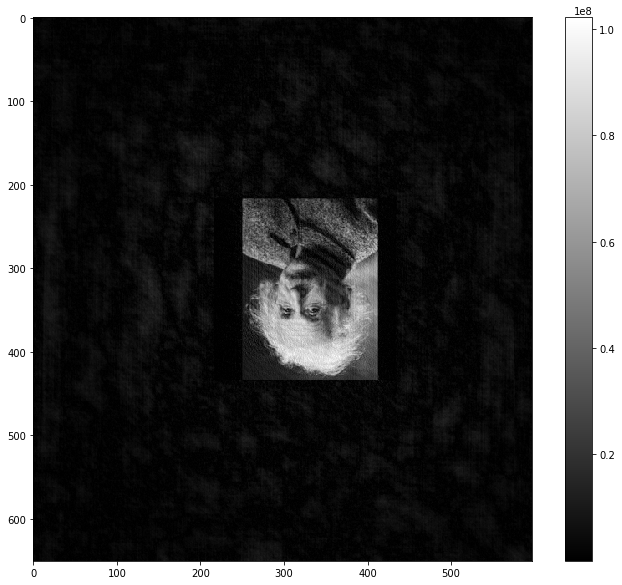

In [6]:
plt.figure(figsize=(12,10))

plt.imshow(np.fft.ifftshift(np.abs(guess_real_space)),cmap='gray')
plt.colorbar()
plt.show()